In [156]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [212]:
df = pd.read_csv('train.csv')

df.drop(columns=['id', 'clean_title'], inplace=True)

In [158]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,8250
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,15000
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,63500
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,7850


In [159]:
df.shape

(54273, 11)

##  Checking for missing values

In [160]:
df.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

## Data anaylsis

In [161]:
df.describe()

,model_year,milage,price
count,54273.000000,54273.000000,5.427300e+04
mean,2015.091979,72746.175667,3.921844e+04
std,5.588909,50469.490448,7.282634e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,32268.000000,1.550000e+04
50%,2016.000000,66107.000000,2.800000e+04
75%,2019.000000,102000.000000,4.500000e+04
max,2024.000000,405000.000000,2.954083e+06


In [162]:
print(df.columns)

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'price'],
      dtype='object')


In [163]:
numeric_columns = df.select_dtypes(include=[int, float]).columns
categorical_columns = df.select_dtypes(include=[object]).columns
print(numeric_columns)
print(categorical_columns
      )

Index(['model_year', 'milage', 'price'], dtype='object')
Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident'],
      dtype='object')


/var/folders/bd/126yvkv50d1cjxc0144dqz4c0000gn/T/ipykernel_70387/2388560778.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


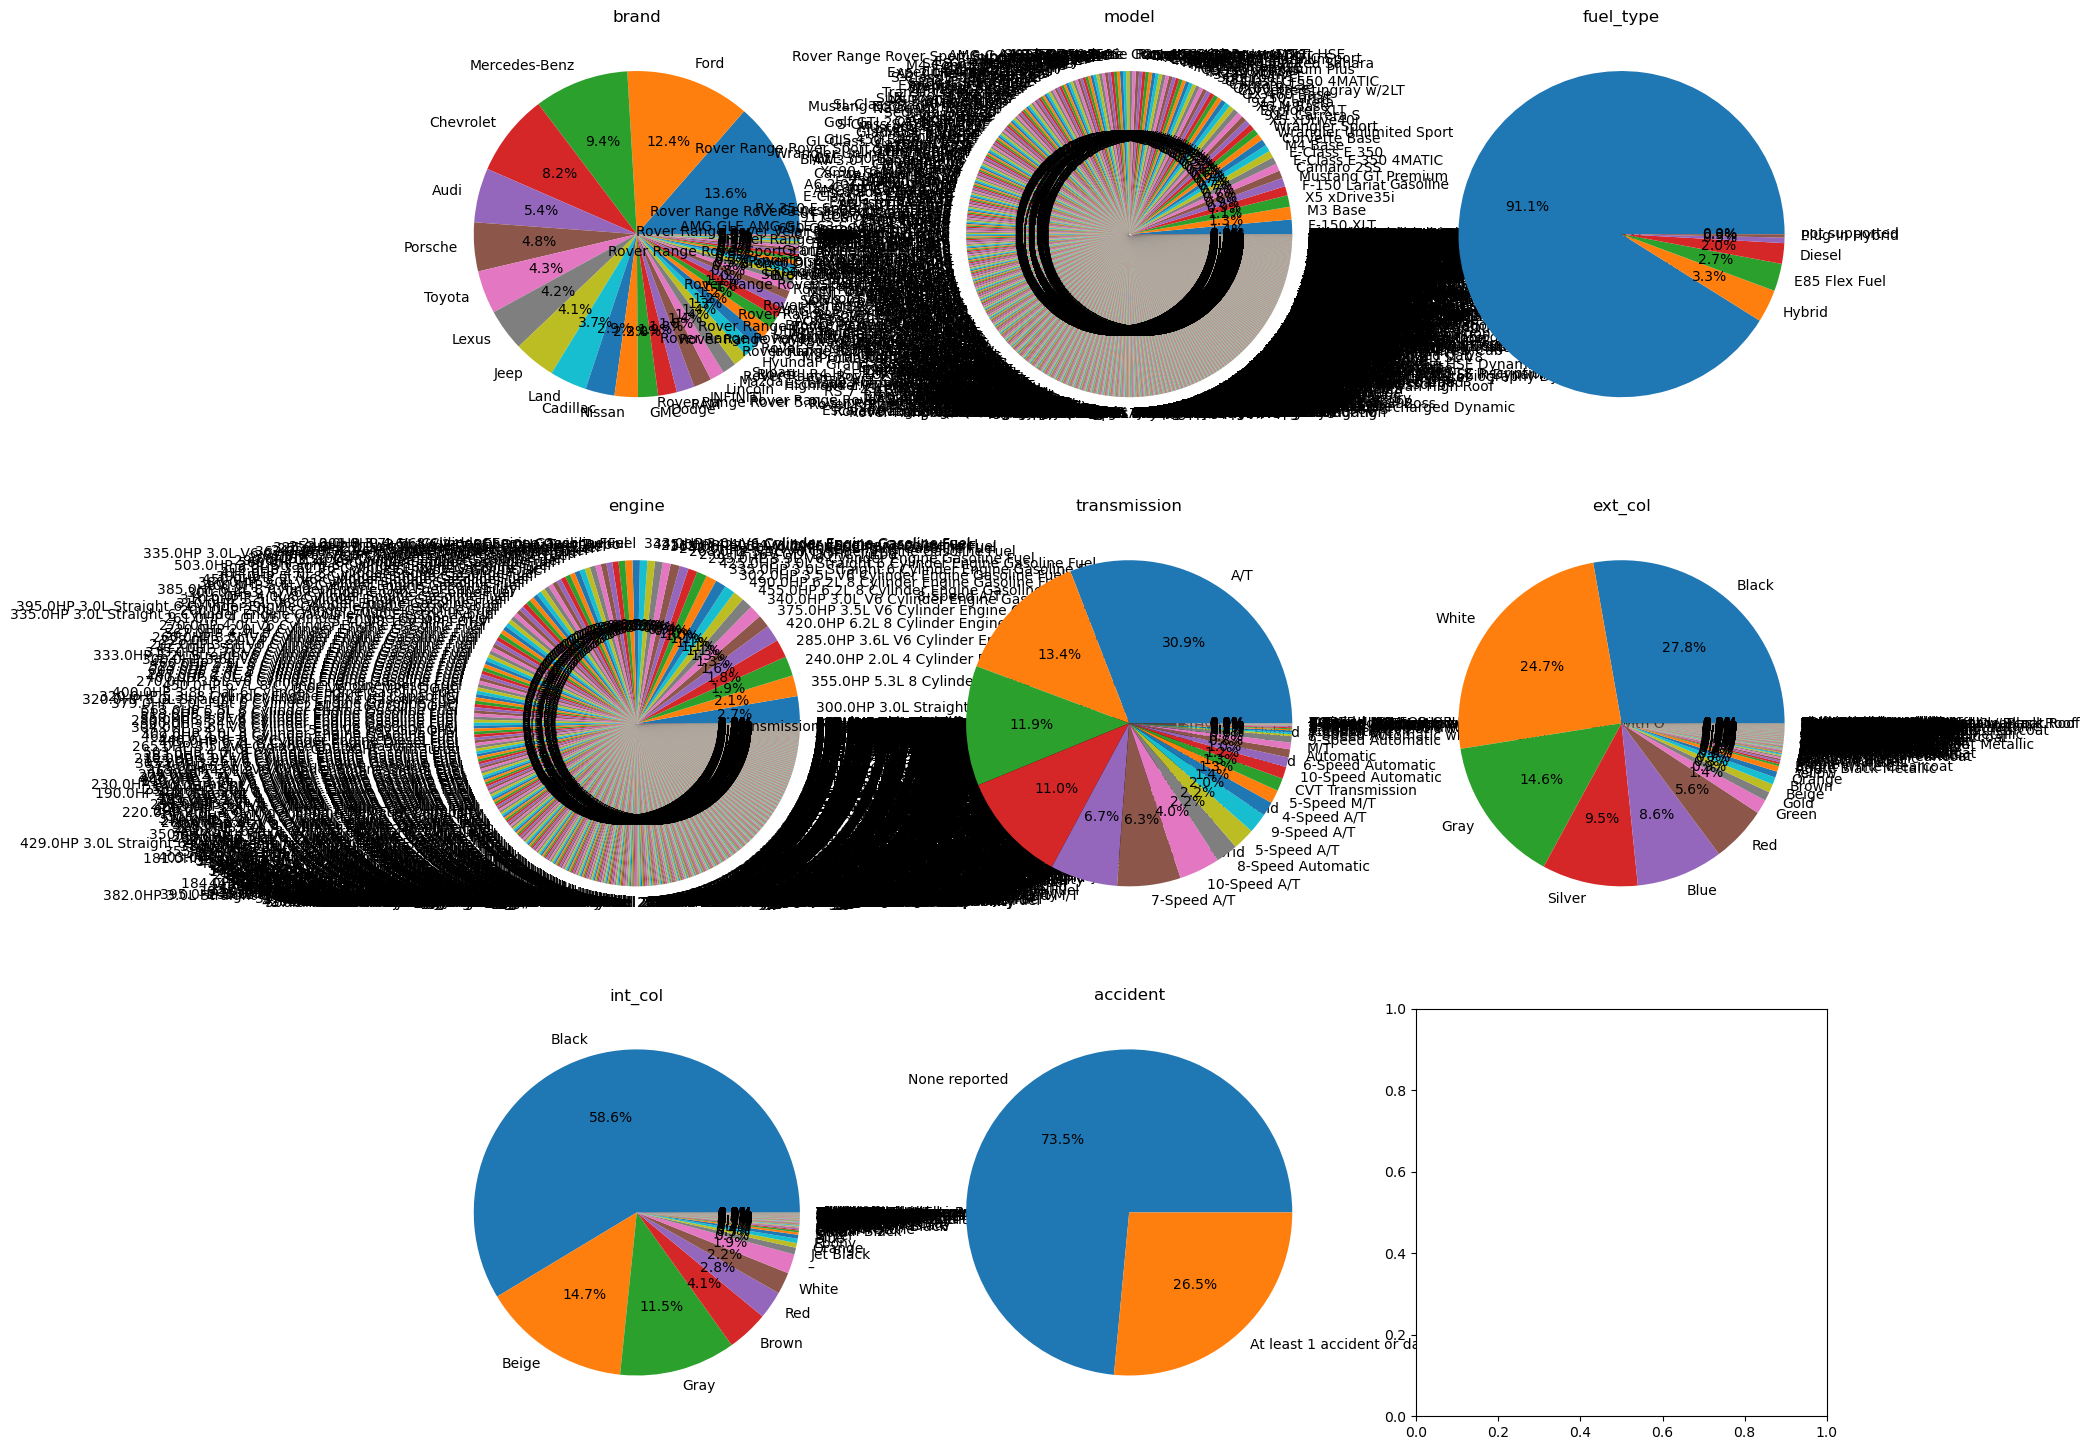

In [164]:
fig, axs = plt.subplots(3,3, figsize=(18,18))

for ax,col in zip(axs.flat, categorical_columns):
    count = df[col].value_counts()
    ax.pie(count, labels = count.index, autopct='%1.1f%%' )
    ax.set_title(col)
    

plt.tight_layout()
plt.show()


# preprocess data

In [165]:
X = df.drop(columns=['price'])
y = df['price']

X.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported


#### Color

In [169]:

int_col_values = X['int_col'].value_counts()
selected_values = int_col_values[int_col_values > 1000].index.tolist()

def int_color_encoder(row):
    
    # more frequent value
    if row['int_col'] == '–':
        return 'Black'
    
    for freq_color in reversed(selected_values):

        if freq_color in row['int_col']:
            return freq_color
    return 'Other'

df['int_col'] = df.apply(int_color_encoder, axis = 1)
print(df['int_col'].value_counts())
    

int_col
Black    33389
Beige     8041
Gray      6321
Brown     2263
Red       1563
Other     1495
White     1201
Name: count, dtype: int64


In [184]:
ext_color = df['ext_col'].value_counts()
selected_values = ext_color[ext_color > 500].index.tolist()

def ext_color_encoder(row):
    
    for freq_color in reversed(selected_values):

        if freq_color in row['ext_col']:
            return freq_color
    return 'Other'

df['ext_col'] = df.apply(ext_color_encoder, axis = 1)
print(df['ext_col'].value_counts())

ext_col
Black     15672
White     13825
Gray       8020
Silver     5361
Blue       4793
Red        3271
Other      2547
Green       784
Name: count, dtype: int64


#### Fuel

In [176]:
def fuel_encoder(row):
    
    if row['fuel_type'] in "–not supported": 
        return 'Gasoline'
    return row['fuel_type']
df['fuel_type'] = df.apply(fuel_encoder, axis = 1)

print(df['fuel_type'].value_counts())


fuel_type
Gasoline          49737
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
Plug-In Hybrid      182
Name: count, dtype: int64


#### Make(brand) and model

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52],
 [Text(0, 0, 'Acura'),
  Text(1, 0, 'Alfa'),
  Text(2, 0, 'Aston'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'BMW'),
  Text(5, 0, 'Bentley'),
  Text(6, 0, 'Bugatti'),
  Text(7, 0, 'Buick'),
  Text(8, 0, 'Cadillac'),
  Text(9, 0, 'Chevrolet'),
  Text(10, 0, 'Chrysler'),
  Text(11, 0, 'Dodge'),
  Text(12, 0, 'FIAT'),
  Text(13, 0, 'Ferrari'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'GMC'),
  Text(16, 0, 'Genesis'),
  Text(17, 0, 'Honda'),
  Text(18, 0, 'Hummer'),
  Text(19, 0, 'Hyundai'),
  Text(20, 0, 'INFINITI'),
  Text(21, 0, 'Jaguar'),
  Text(22, 0, 'Jeep'),
  Text(23, 0, 'Kia'),
  Text(24, 0, 'Lamborghini'),
  Text(25, 0, 'Land'),
  Text(26, 0, 'Lexus'),
  Text(27, 0, 'Lincoln'),
  Text(2

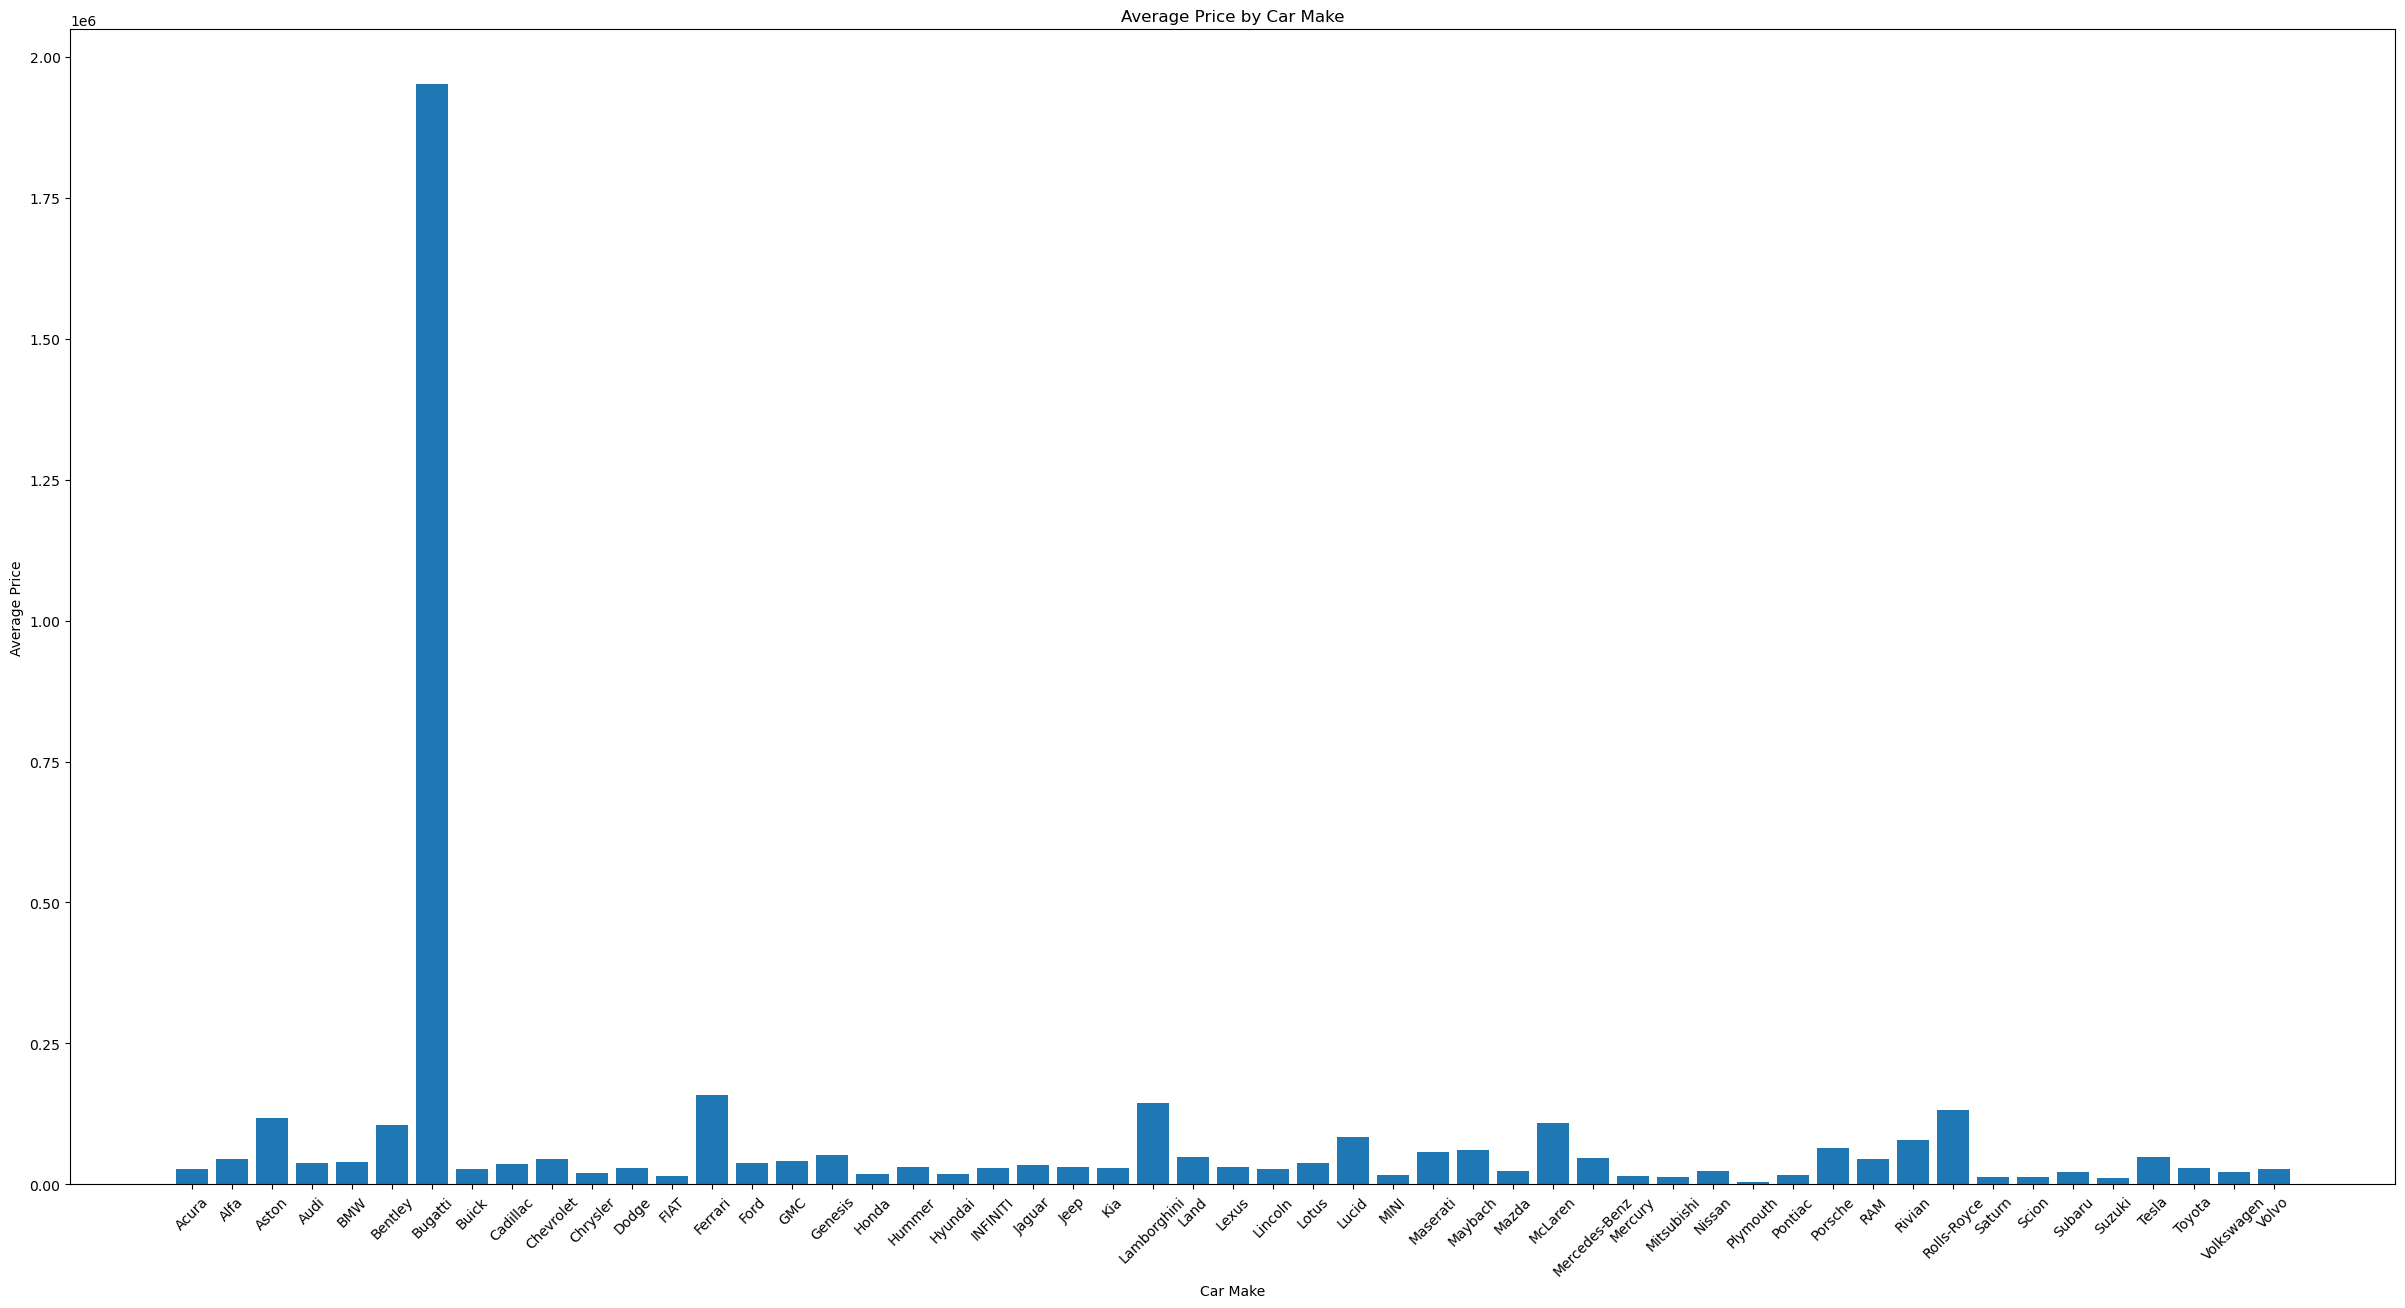

In [194]:
average_price = df.groupby('brand')['price'].mean().reset_index()
plt.figure(figsize=(30, 15))

plt.bar(average_price['brand'], average_price['price'])
plt.xlabel('Car Make')
plt.ylabel('Average Price')
plt.title('Average Price by Car Make')
plt.xticks(rotation=45)

In [200]:
print(X['brand'].value_counts())

brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2315
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1252
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              50
McLaren            43
Rivian             27
Merc

In [213]:
# expensive cars
exotic_brands = list(average_price.sort_values(by='price', ascending=False).head(10)['brand'])
brand_values = X['brand'].value_counts()
selected_values = brand_values[brand_values > 500].index.tolist()

def brand_encoder(row):

    if row['brand'] in exotic_brands:
        return 'Exotic'
    
    if row['brand'] in selected_values:
        return row['brand']
    
    return 'Other'

df['brand'] = df.apply(brand_encoder, axis=1)
print(df['brand'].value_counts())



brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Exotic           3385
Audi             2922
Other            2772
Toyota           2315
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1252
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Name: count, dtype: int64


In [217]:
df['model'].value_counts()

model
F-150 XLT             780
M3 Base               682
X5 xDrive35i          615
F-150 Lariat          496
Mustang GT Premium    466
                     ... 
Suburban 2500           1
TLX Tech                1
Rogue Sport S           1
A8 4.0                  1
S-10 LS                 1
Name: count, Length: 1827, dtype: int64

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

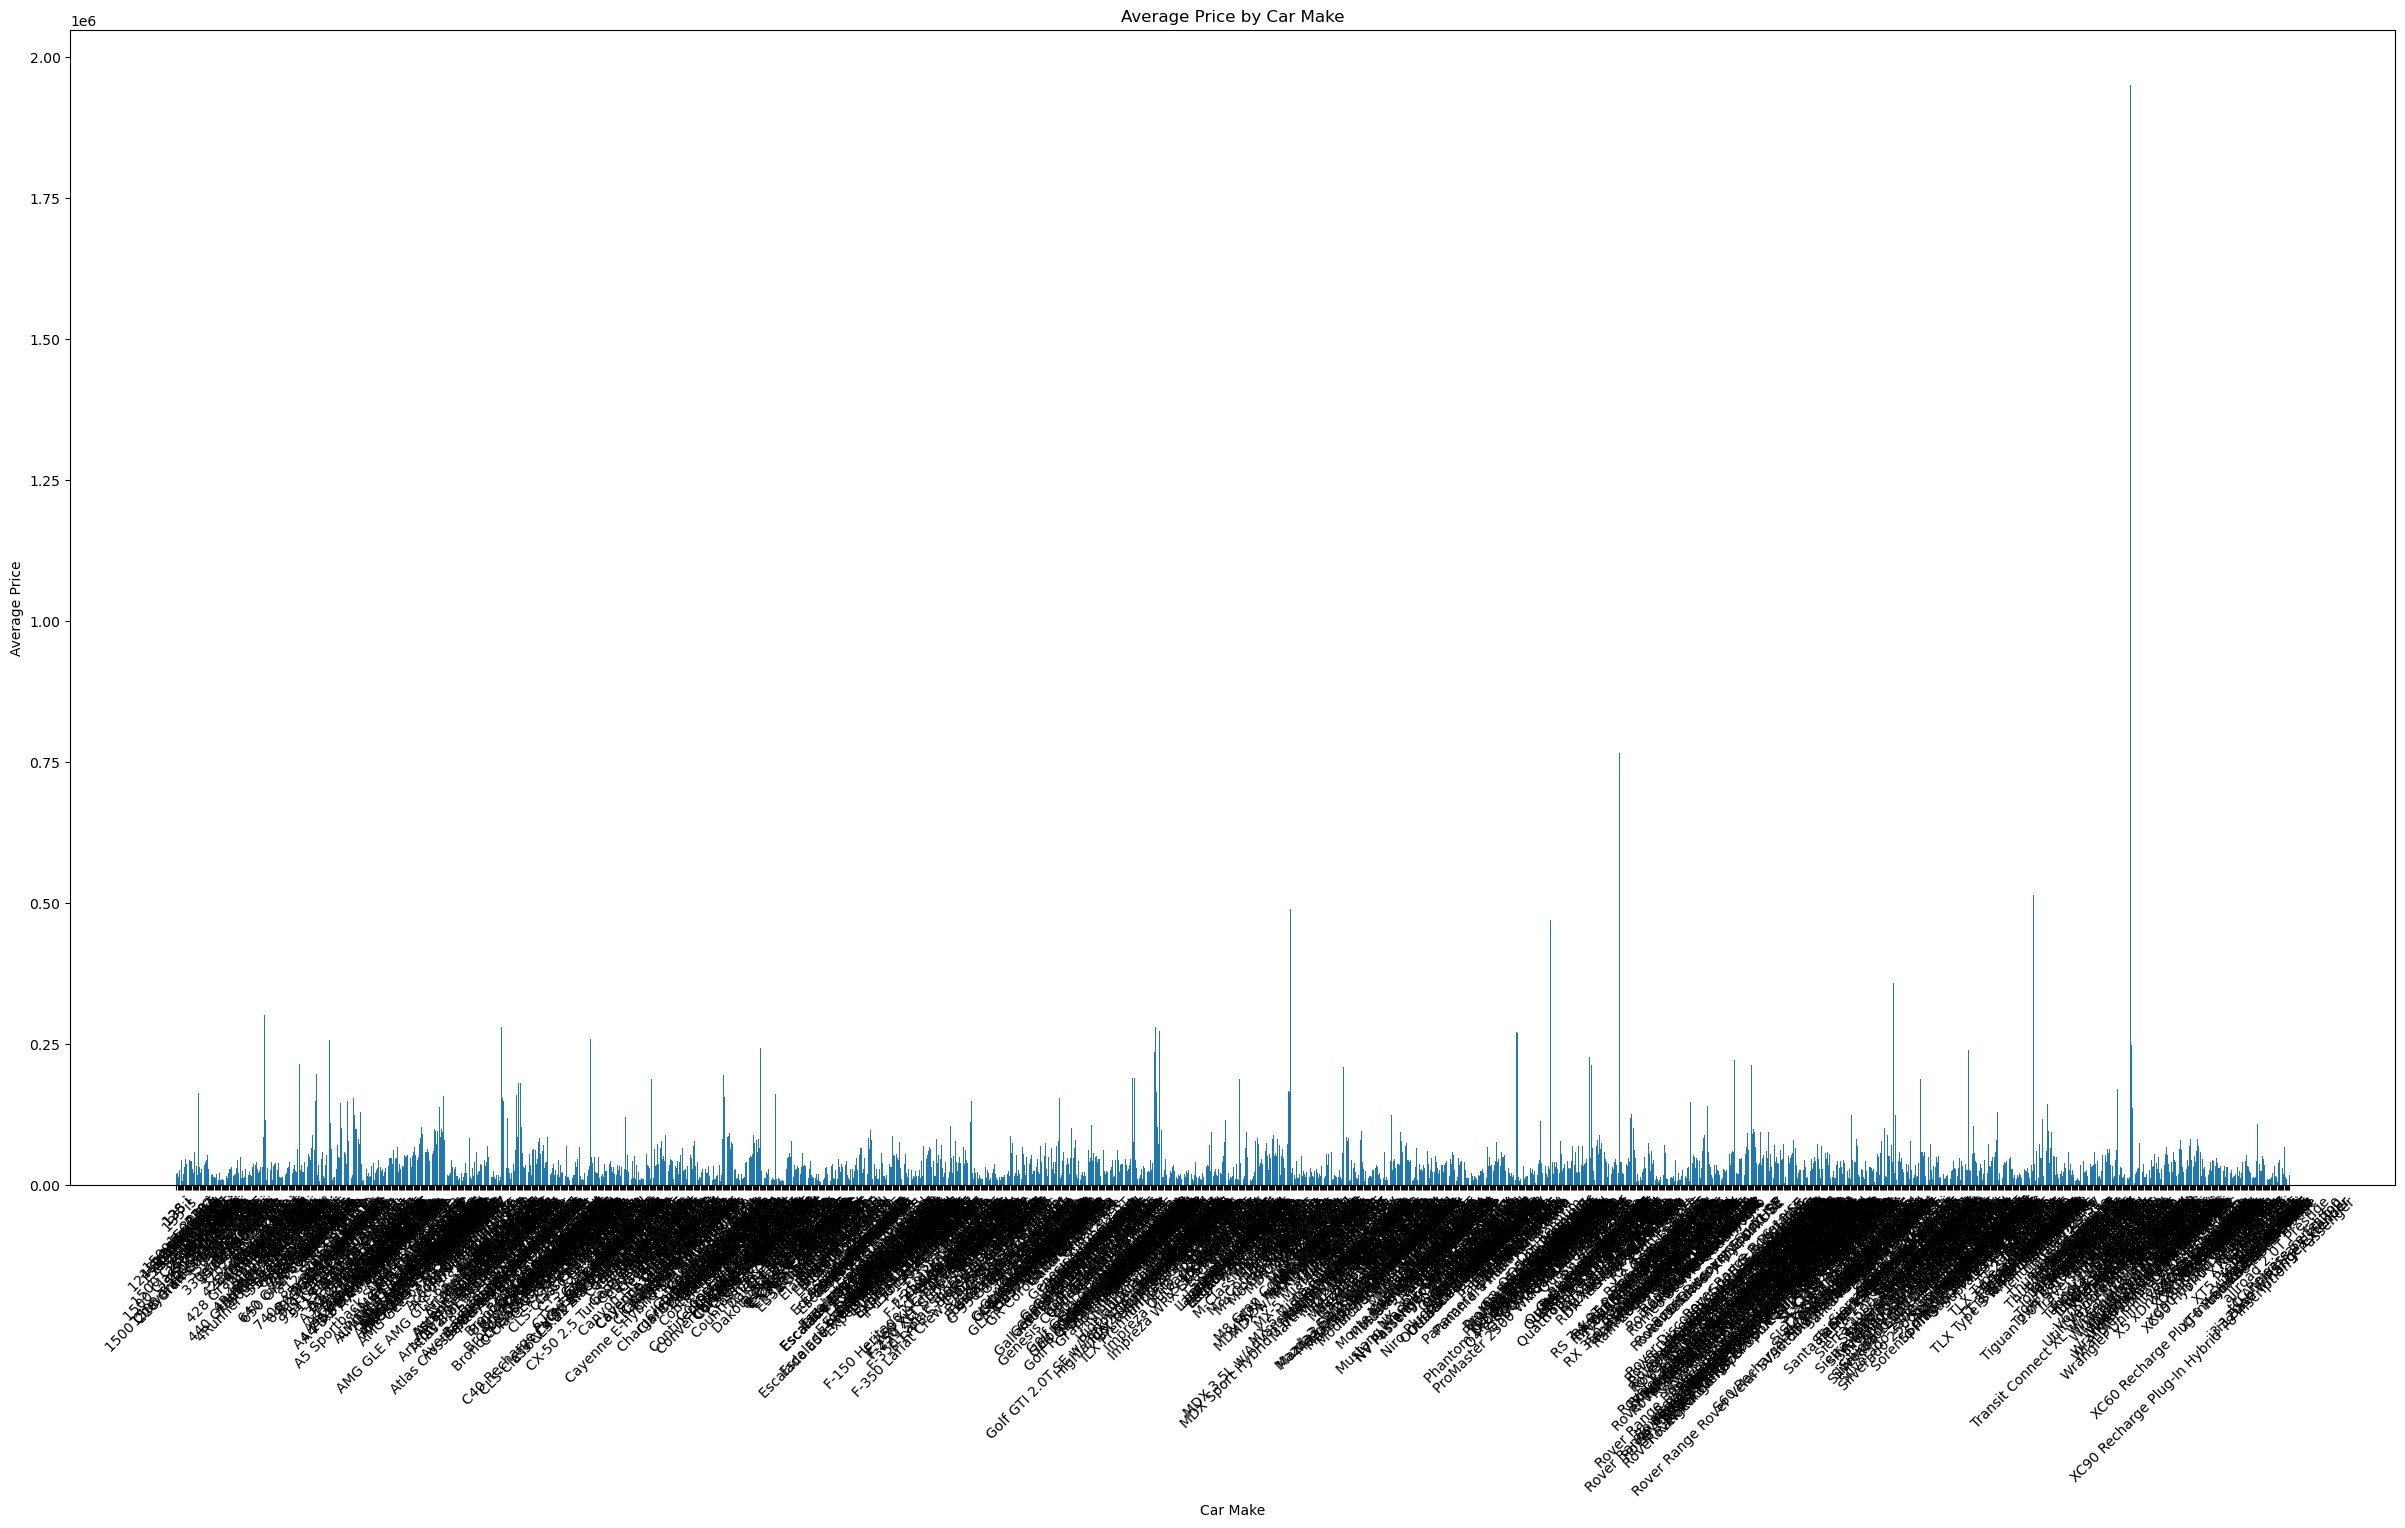

In [216]:
average_price = df.groupby('model')['price'].mean().reset_index()
plt.figure(figsize=(30, 15))

plt.bar(average_price['model'], average_price['price'])
plt.xlabel('Car Make')
plt.ylabel('Average Price')
plt.title('Average Price by Car Make')
plt.xticks(rotation=45)

In [219]:
from sklearn.preprocessing import LabelEncoder

q75 = average_price['price'].quantile(0.75)
q50 = average_price['price'].quantile(0.50)


expensive_price = average_price[average_price['price'] > q75]
high_price = average_price[average_price['price'] > q50]
low_price = average_price[average_price['price'] <= q50]

def model_price_encoder(row):
    
    if row['model'] in expensive_price['model'].values:
        return 'Expensive'
    
    if row['model'] in high_price['model'].values:
        return 'High'
    
    if row['model'] in low_price['model'].values:
        return 'Low'
    
    return 'Other'

df['model_tier'] = df.apply(model_price_encoder, axis=1)
print(df['model_tier'].value_counts())

# target encode the model column
lbEncoder = LabelEncoder()
df['model'] = lbEncoder.fit_transform(df['model'])

df['model'].value_counts()


model_tier
Low          23705
High         16569
Expensive    13999
Name: count, dtype: int64


model
654     780
939     682
1737    615
644     496
1078    466
       ... 
1564      1
1583      1
1308      1
194       1
1390      1
Name: count, Length: 1827, dtype: int64

#### Transmission

In [222]:
print(df['transmission'].value_counts())
df['transmission'] = lbEncoder.fit_transform(df['transmission'])

df['engine'] = lbEncoder.fit_transform(df['engine'])

transmission
A/T                                                   16757
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6454
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

#### engine

In [223]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,model_tier
0,Ford,644,2018,74349,Gasoline,719,2,Blue,Gray,None reported,11000,High
1,BMW,49,2007,80000,Gasoline,534,18,Black,Black,None reported,8250,Low
2,Jaguar,1771,2009,91491,Gasoline,541,14,Purple,Beige,None reported,15000,Low
3,BMW,1748,2022,2437,Hybrid,646,43,Gray,Brown,None reported,63500,Expensive
4,Other,693,2001,111000,Gasoline,219,34,White,Black,None reported,7850,Low


In [224]:
X = df.drop(columns=['price'])
y = df['price']

In [225]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes(include="object").columns



In [226]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("scaler", scaler, num_cols),
        ("encoder", encoder, cat_cols)
    ]
)

In [227]:
test = pd.read_csv('test.csv')
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes


In [ ]:
print(X.head())

     brand          model  model_year  milage fuel_type  \
0     Ford   F-150 Lariat        2018   74349  Gasoline   
1      BMW          335 i        2007   80000  Gasoline   
2   Jaguar      XF Luxury        2009   91491  Gasoline   
3      BMW   X7 xDrive40i        2022    2437    Hybrid   
4  Pontiac  Firebird Base        2001  111000  Gasoline   

                                              engine  \
0      375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel   
1  300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...   
2       300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel   
3  335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...   
4      200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col       accident  
0                    10-Speed A/T    Blue    Gray  None reported  
1                     6-Speed M/T   Black   Black  None reported  
2                     6-Speed A/T  Purple   Beige  None reported  
3  Transmission w/Dual Shift Mode    Gra

In [ ]:

id = test['id']
test.drop(columns=['id'],inplace=True)
X_combined = pd.concat([X, test], ignore_index=True)
X_combined = preprocessor.fit_transform(X_combined)
X_combined = pd.DataFrame.sparse.from_spmatrix(X_combined)
X_length = X.shape[0]

X = X_combined.iloc[:X_length, :]
test = X_combined.iloc[X_length:, :]

In [228]:
X = preprocessor.fit_transform(X)

In [229]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, test.shape

((43418, 427), (10855, 427), (36183, 12))

In [230]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from xgboost import XGBRegressor


models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [231]:
from sklearn.metrics import mean_squared_error, r2_score

model_list = []
r2_list = []

for model_name, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f'Model: {model_name}')
    print("- Mean Squared Error: {:.4f}".format(mse))
    print("- R2 score: {:.4f}".format(r2))
    print('===============================================================\n\n')

    model_list.append(model_name)
    r2_list.append(r2)

Model: Linear Regression
- Mean Squared Error: 2328384684.5304
- R2 score: 0.2076


Model: Lasso
- Mean Squared Error: 2323770926.1475
- R2 score: 0.2092


Model: Ridge
- Mean Squared Error: 2325729723.5735
- R2 score: 0.2085


Model: K-Neighbors Regressor
- Mean Squared Error: 2917054502.8606
- R2 score: 0.0073


Model: Decision Tree
- Mean Squared Error: 6838414137.0695
- R2 score: -1.3272


Model: Random Forest Regressor
- Mean Squared Error: 2922641644.3682
- R2 score: 0.0054


Model: XGBRegressor
- Mean Squared Error: 3036947204.3792
- R2 score: -0.0335


Model: AdaBoost Regressor
- Mean Squared Error: 5707614338.5328
- R2 score: -0.9424




In [ ]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.167296
1,Lasso,0.085302
3,K-Neighbors Regressor,0.003364
6,XGBRegressor,-0.002733
0,Linear Regression,-0.045869
5,Random Forest Regressor,-0.113461
4,Decision Tree,-0.921424
7,AdaBoost Regressor,-6.950374


AttributeError: 'csr_matrix' object has no attribute 'head'

In [ ]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,3448,3449,3450,3451,3452,3453,3454,3455,3456,3457
54273,-0.193373,0.007131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54274,-0.014451,1.095420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54275,-0.014451,-0.408492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
54276,0.522314,-0.853107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
54277,0.880158,0.343316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
final_model = Ridge()
final_model.fit(X_train, y_train)


price = final_model.predict(test)


output = pd.DataFrame({'id': id, 'price': price})
output.to_csv('pred.csv', index=False)
